In [377]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import copy

In [2]:
client = MongoClient()
db = client.heroku_rnwkcq9r

In [625]:
def user_name(user_id):
    user = db.user.find_one({'_id':user_id})
    return user['name']

def question_text(question_id):
    question = db.question.find_one({'_id': question_id})
    return question['text']

def handin_of_assignment(handin_id):
    '''Finds the assignment id that the handin belongs to '''
    handin = db.handin.find_one({'_id': handin_id})
    return handin['assignment']

def question_max_value(question_id):
    question = db.question.find_one({'_id': question_id})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 5

def answer_value(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))

#def answer_with_score(answer_id):
#    answer = db.answer.find_one({'_id': answer_id})
#    return 'text_answer' not in answer

def have_graded_handin(handin_id,grader_id):
    report_grade = db.report_grade.find({'handin': handin_id, 'giver': grader_id})
    if report_grade.count() != 0:
        return True
    return False

def score_handin_grader(handin_id,grader_id):
    # find all answers to the hand in of the grader and average it out
    report_grade = db.report_grade.find_one({'handin': handin_id, 'giver': grader_id})
    answers = db.answer.find({'report_grade': report_grade['_id'], 'text_answer': { '$exists': False } })
    handin_acc = 0.0
    for answer in answers:
        handin_acc = handin_acc + answer_value(answer['_id'])
    return handin_acc / answers.count()

def score_handin_list(handin_id):
    scores = list()
    report_grades = db.report_grade.find({'handin': handin_id, 'state': 'ANSWERED'})
    for report_grade in report_grades:
        if report_grade['giver'] not in [ObjectId("56151d31ed0827000f7ad204"),ObjectId("56151d6bed0827000f7ad205")]:
            scores.append((score_handin_grader(handin_id,report_grade['giver']),report_grade['giver']))
    return scores

def question_index(handin_id):
    order = list()
    handin = db.handin.find_one({'_id':handin_id})
    assignment = db.assignment.find_one({'_id': handin['assignment']})
    for section_id in assignment['sections']:
        section = db.question_section.find_one({'_id': section_id})
        for question_id in section['questions']:
            question = db.question.find_one({'_id': question_id})
            if question['question_type'] != 'text':
                order.append(question['_id'])
    q_dict = dict()
    for i, q_id in enumerate(order):
        q_dict[str(q_id)] = i
    return q_dict

    # Find Assignment
    # Find sections
        # Find all question
            # Store all question that are not text, so Boolean or numerical

def answer_handin_grader(handin_id,grader_id):
    # find all answers to the handin of a grader
    report_grade = db.report_grade.find_one({'handin': handin_id, 'giver': grader_id})
    answers = db.answer.find({'report_grade': report_grade['_id'], 'text_answer': { '$exists': False } })
    
    # Find the dict of with the question and their proper index.
    q_dict = question_index(handin_id)
    
    acc = [0 for x in xrange(answers.count())]
    for answer in answers:
        # Ensure that the order of the questions are correct
        ind = q_dict[str(answer['question'])]
        acc[ind] = answer_value(answer['_id'])
    return acc

def answer_handin(handin_id):
    scores = list()
    report_grades = db.report_grade.find({'handin': handin_id, 'state': 'ANSWERED'})
    for report_grade in report_grades:
        if report_grade['giver'] not in [ObjectId("56151d31ed0827000f7ad204"),ObjectId("56151d6bed0827000f7ad205")]:
            scores.append((answer_handin_grader(handin_id,report_grade['giver']),report_grade['giver']))
    return scores

# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append((score_handin_list(handin['_id']),handin['_id']))
    return handins_reports

# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins_id(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append(handin['_id'])
    return handins_reports

In [236]:
def handin_model(data):
    N_H = len(data)
    
    # Bias
#    T = dict()
#    B = dict()
    B_mu = dict()
    B_tau = dict()
    T_mu = dict()
    T_tau = dict()
    O = list()

    for h in range(0, N_H):
        (scores,h_id) = data[h]
        N_G = len(scores)
        
        T_mu[h_id] = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau[h_id] = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        
        for g in range(0, N_G):
            (val,g_id) = scores[g]

            if g_id not in B_mu:
                B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
            if g_id not in B_tau:
                B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)

            O.append(pm.Normal('O_%(h)s_%(g)s' % {'h': h, 'g':g}, mu = T_mu[h_id] + B_mu[g_id], tau = T_tau[h_id]+B_tau[g_id], observed=True, value=val))
        
            
    collection = [pm.Container(T_tau),
                  pm.Container(T_mu),
                  pm.Container(B_tau),
                  pm.Container(B_mu)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [233]:
def execute_model(model,samples):
    mcmc = pm.MCMC(model)
    mcmc.sample(samples)
    return mcmc

In [234]:
def run_3_iteration(model_,values,samples):
    model_back = model_(values)
    mcmc_back_1 = execute_model(model_back,samples)
    mcmc_back_2 = execute_model(model_back,samples)
    mcmc_back_3 = execute_model(model_back,samples)
    return [mcmc_back_1,mcmc_back_2,mcmc_back_3]

### Assignment 1

In [200]:
data_assignment_1 = assignment_handins(ObjectId("5602625c568a61000f81eddd"))

In [237]:
mcmc = run_3_iteration(handin_model,data_assignment_1,1500)

 [-----------------100%-----------------] 1500 of 1500 complete in 37.3 sec

In [550]:
def student_id(user_id):
    student = db.user.find_one({'_id': user_id})
    if '@student.dtu.dk' in student['email']:
        return student['email'][:7]
    else:
        return student['email']
    
def get_TA_scores(assignment_id, calc_mean=True):
    TA1_Scores = dict()
    TA2_Scores = dict()
    if assignment_id != ObjectId("562d0edb79c852000f99c6dd"):
        Ass1B = defaultdict(list, json.load(open('SocialGraph/Ass1Bjarke.json')) )
        Ass1S = defaultdict(list, json.load(open('SocialGraph/Ass1Snorre.json')) )    

    
    questions_norm = []
    for section_id in db.assignment.find_one({'_id': assignment_id})['sections']:
        for question_id in db.question_section.find_one({'_id': section_id})['questions']:
            q = db.question.find_one({'_id': question_id})
            if q['question_type'] == 'numerical' or q['question_type'] == 'boolean':
                norm = 3.0 if q['question_type'] == 'numerical' else 1.0
                questions_norm.append(norm)
                
    # Find the TA scores for the handins
    for handin in db.handin.find({'assignment': assignment_id}):
        studentId = student_id(handin['submitter'])
        # Hot fix
        handin_scores_ta1 = list()
        handin_scores_ta2 = list()
        
        # Fetch relevant data
        if assignment_id == ObjectId("562d0edb79c852000f99c6dd"):
            if have_graded_handin(handin['_id'],ObjectId("56151d31ed0827000f7ad204")):
                handin_scores_ta1 = answer_handin_grader(handin['_id'],ObjectId("56151d31ed0827000f7ad204"))
            if have_graded_handin(handin['_id'],ObjectId("56151d6bed0827000f7ad205")):
                handin_scores_ta2 = answer_handin_grader(handin['_id'],ObjectId("56151d6bed0827000f7ad205"))
        else:
            for index, question_norm in enumerate(questions_norm):
                if studentId in Ass1B:
                    handin_scores_ta1.append(Ass1B[studentId][index] / question_norm)
                if studentId in Ass1S:
                    handin_scores_ta2.append(Ass1S[studentId][index] / question_norm)

        if len(handin_scores_ta1) != 0:
            if calc_mean:
                TA1_Scores[str(handin['_id'])] = np.mean(handin_scores_ta1)
            else:
                TA1_Scores[str(handin['_id'])] = handin_scores_ta1
        if len(handin_scores_ta2) != 0:
            if calc_mean:
                TA2_Scores[str(handin['_id'])] = np.mean(handin_scores_ta2)
            else:
                TA2_Scores[str(handin['_id'])] = handin_scores_ta2

    return TA1_Scores, TA2_Scores

In [219]:
def plot_result_ass1(_id,data,mcmc,find,func=np.mean):
    data_1 = find(_id, mcmc[0], func)
    data_2 = find(_id, mcmc[1], func)
    data_3 = find(_id, mcmc[2], func)
    

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = data_1[:]
    collected.extend(data_2[:])
    collected.extend(data_3[:])
    for (value, g_id) in collected:
        compared[g_id].append(value)
    # Produce a box plot where the graders are sorted after mean value of the found values
    ax = plt.subplot(111)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: np.mean(x[1][:]))

    labels = list()
    if 'bias' in find.func_name:
        for (g_id, value) in sorted_list:
            name = grader_name(ObjectId(g_id))
            reported = number_of_reports(ObjectId(g_id), _id)
            labels.append(name + ": " + str(reported))
        values = map(lambda x: x[1], sorted_list)
        plt.boxplot(values,0, vert=False, labels=labels)
        plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)
    else:
        model_points = list()
        ta1_points = list()
        ta1_points_y = list()
        ta2_points = list()
        ta2_points_y = list()
        bp_points = list()
        
        for i, (h_id, value) in enumerate(sorted_list):
            labels.append(h_id)
            model_points.append(func(value))
            TA1_scores, TA2_scores = get_TA_scores(_id)
            if h_id in TA1_scores: 
                ta1_points.append(TA1_scores[h_id])
                ta1_points_y.append(i)

            if h_id in TA2_scores: 
                ta2_points.append(TA2_scores[h_id])
                ta2_points_y.append(i)
            scores = list()
            for (score,_) in score_handin_list(ObjectId(h_id)):
                scores.append(score)
            bp_points.append(scores)

        _i = range(len(sorted_list))
        plt.plot(model_points,_i,'or',alpha = 0.7, label="Model")
        plt.plot(ta1_points,ta1_points_y,'ob',alpha = 0.7, label="TA1")
        plt.plot(ta2_points,ta2_points_y,'og',alpha = 0.7, label="TA2")
        plt.boxplot(bp_points, positions=_i, vert=False)

        plt.yticks(range(len(sorted_list)), labels)
        plt.xlim(0,1)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("gradings")
        plt.ylabel("handins")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width*1.5, box.height*5])

    plt.show()

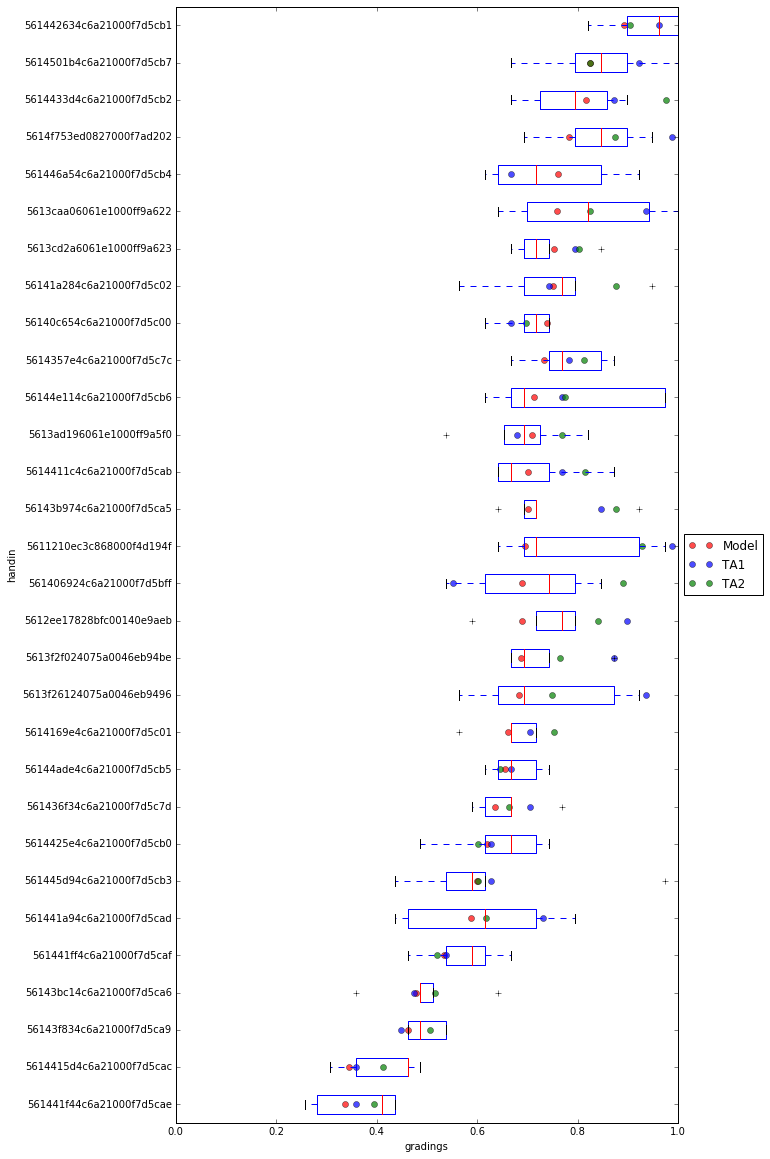

In [220]:
plot_result_ass1(ObjectId("5602625c568a61000f81eddd"),data_assignment_1,mcmc,find_T)

### Assignment 2

In [156]:
data_assignment_2 = assignment_handins(ObjectId("562d0edb79c852000f99c6dd"))

In [157]:
mcmc = run_3_iteration(handin_model,data_assignment_2,1500)

 [-----------------100%-----------------] 1501 of 1500 complete in 51.5 sec

In [158]:
def grader_ids(assignment_id):
    graders = set()
    report_grades = db.report_grade.find({'assignment':assignment_id})
    for report_grade in report_grades:
        graders.add(report_grade['giver'])
    return list(graders)

def grader_ids_course(course_id):
    graders = set()
    course = db.course.find_one({'_id':course_id})
    return course['students']

def grader_id(grader_name):
    grader = db.user.find_one({'name': grader_name})
    return grader['_id']

def grader_name(grader_id):
    grader = db.user.find_one({'_id': grader_id})
    return grader['name']

def find_bias(assignment_id,mcmc,f):
    bias_abs = list()
    for g in grader_ids(assignment_id):
        try:     
            bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
            name = str(g)
            bias_abs.append((bias_mean,name))
        except:
#            print "error for grader: %s" % grader_name(g)
            pass
    return bias_abs

def find_T(assignment_id,mcmc,f):
    bias = list()
    for h in assignment_handins_id(assignment_id):
        try:     
            bias_mean = f(mcmc.trace('T_%s' % str(h))[:])
            name = str(h)
            bias.append((bias_mean,name))
        except:
            #print "error for grader: %s" % grader_name(g)
            pass
    return bias

def number_of_reports(g_id, assignment_id):
    reports = db.report_grade.find({'assignment': assignment_id, 'giver': g_id, 'state': 'ANSWERED'})
    return reports.count()

def number_of_reports_course(g_id, course_id):
    count = 0
    assignments = db.assignment.find({'course': course_id})
    for assignment in assignments:
        reports = db.report_grade.find({'assignment': assignment['_id'], 'giver': g_id, 'state': 'ANSWERED'})
        count = count + reports.count()
    return count

In [230]:
def plot_result(_id,data,mcmc,find,func=np.mean):
    data_1 = find(_id, mcmc[0], func)
    data_2 = find(_id, mcmc[1], func)
    data_3 = find(_id, mcmc[2], func)
    

    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = data_1[:]
    collected.extend(data_2[:])
    collected.extend(data_3[:])
    for (value, g_id) in collected:
        compared[g_id].append(value)
        
    # Produce a box plot where the graders are sorted after mean value of the found values
    ax = plt.subplot(111)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: np.mean(x[1][:]))

    labels = list()
    if 'bias' in find.func_name:
        for (g_id, value) in sorted_list:
            name = grader_name(ObjectId(g_id))
            reported = number_of_reports(ObjectId(g_id), _id)
            labels.append(name + ": " + str(reported))
        values = map(lambda x: x[1], sorted_list)
        plt.boxplot(values,0, vert=False, labels=labels)
        plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)
    else:
        model_points = list()
        ta1_points = list()
        ta1_points_y = list()
        ta2_points = list()
        ta2_points_y = list()
        bp_points = list()
        for i, (h_id, value) in enumerate(sorted_list):
            labels.append(h_id)
            model_points.append(func(value))
            TA1_scores, TA2_scores = get_TA_scores(_id)
            if have_graded_handin(ObjectId(h_id),ObjectId("56151d6bed0827000f7ad205")):
                ta1_points.append(score_handin_grader(ObjectId(h_id),ObjectId("56151d6bed0827000f7ad205")))
                ta1_points_y.append(i)
            if have_graded_handin(ObjectId(h_id),ObjectId("56151d31ed0827000f7ad204")):
                ta1_points.append(score_handin_grader(ObjectId(h_id),ObjectId("56151d31ed0827000f7ad204")))
                ta1_points_y.append(i)
            scores = list()
            print "test"
            for (score,_) in score_handin_list(ObjectId(h_id)):
                scores.append(score)
            bp_points.append(scores)

        _i = range(len(sorted_list))
        plt.plot(model_points,_i,'or',alpha = 0.7, label="Model")
        plt.plot(ta1_points,ta1_points_y,'ob',alpha = 0.7, label="TA1")
        plt.plot(ta2_points,ta2_points_y,'og',alpha = 0.7, label="TA2")
        print len(bp_points)
        plt.boxplot(bp_points, positions=_i, vert=False)

        plt.yticks(range(len(sorted_list)), labels)
        plt.xlim(0,1)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xlabel("gradings")
        plt.ylabel("handin")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width*1.5, box.height*5])

#    plt.xlabel("Absolute mean value of the bias distributions of a grader")
    plt.show()

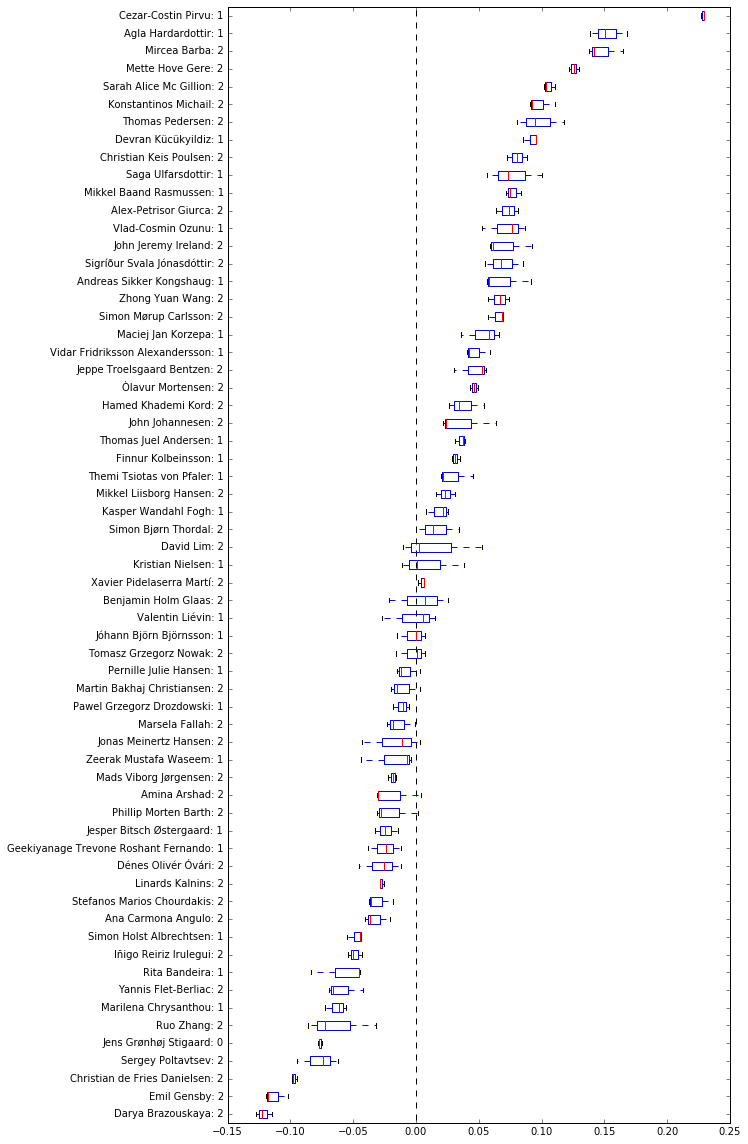

In [226]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_assignment_2,mcmc,find_bias)

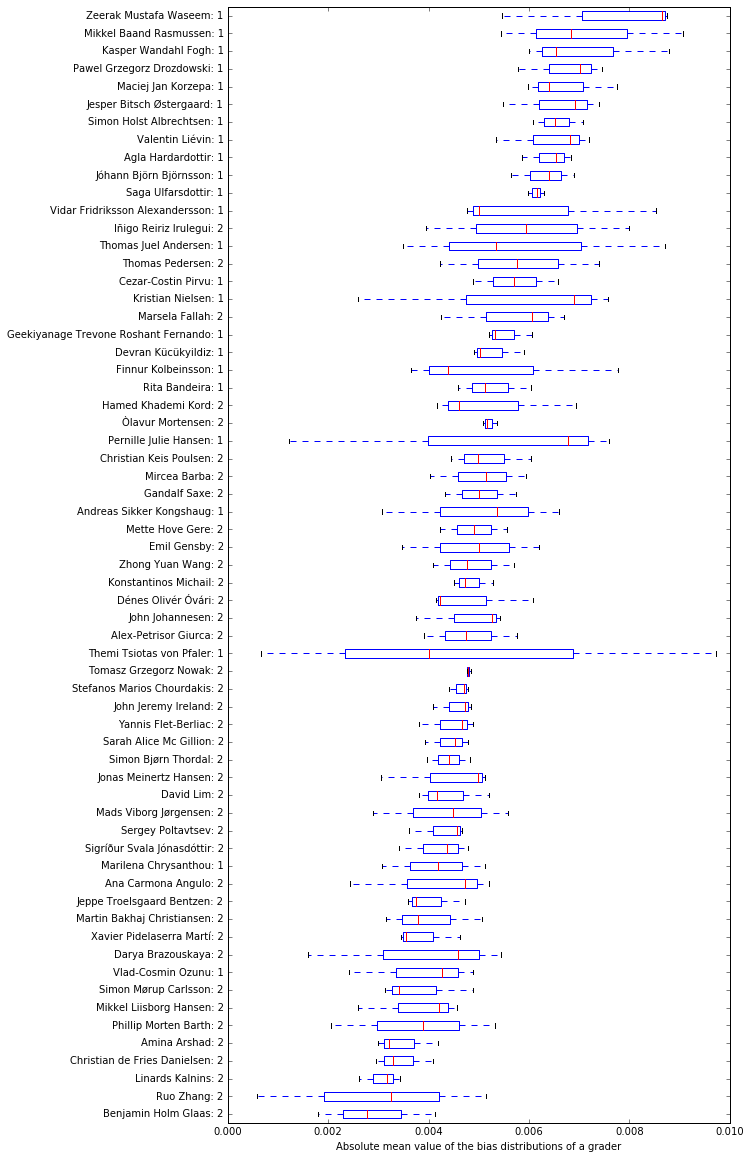

In [161]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_assignment_2,mcmc,find_bias,np.var)

0


IndexError: list index out of range

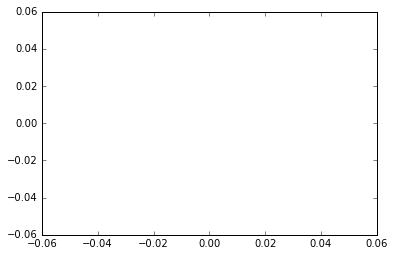

In [553]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_assignment_2,mcmc,find_T)

### All assignments

In [165]:
def course_handins(course_id):
    handins = list()
    assignments = db.assignment.find({'course':course_id})
    for assignment in assignments:
        handins.extend(assignment_handins(assignment['_id']))
    return handins

In [166]:
# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def course_handins_id(course_id):
    handins_reports = list()
    assignments = db.assignment.find({'course': course_id})
    for assignment in assignments:
        handins = db.handin.find({'assignment': assignment['_id']})
        for handin in handins:
            handins_reports.append(handin['_id'])
    return handins_reports

In [167]:
data_course = course_handins(ObjectId("55ffbaf722913c000f1bf8fd"))

In [168]:
mcmc_c = run_3_iteration(handin_model,data_course,1500)

 [-----------------100%-----------------] 1500 of 1500 complete in 113.4 sec

#### Assignment 1 Modeled on all data with TAs

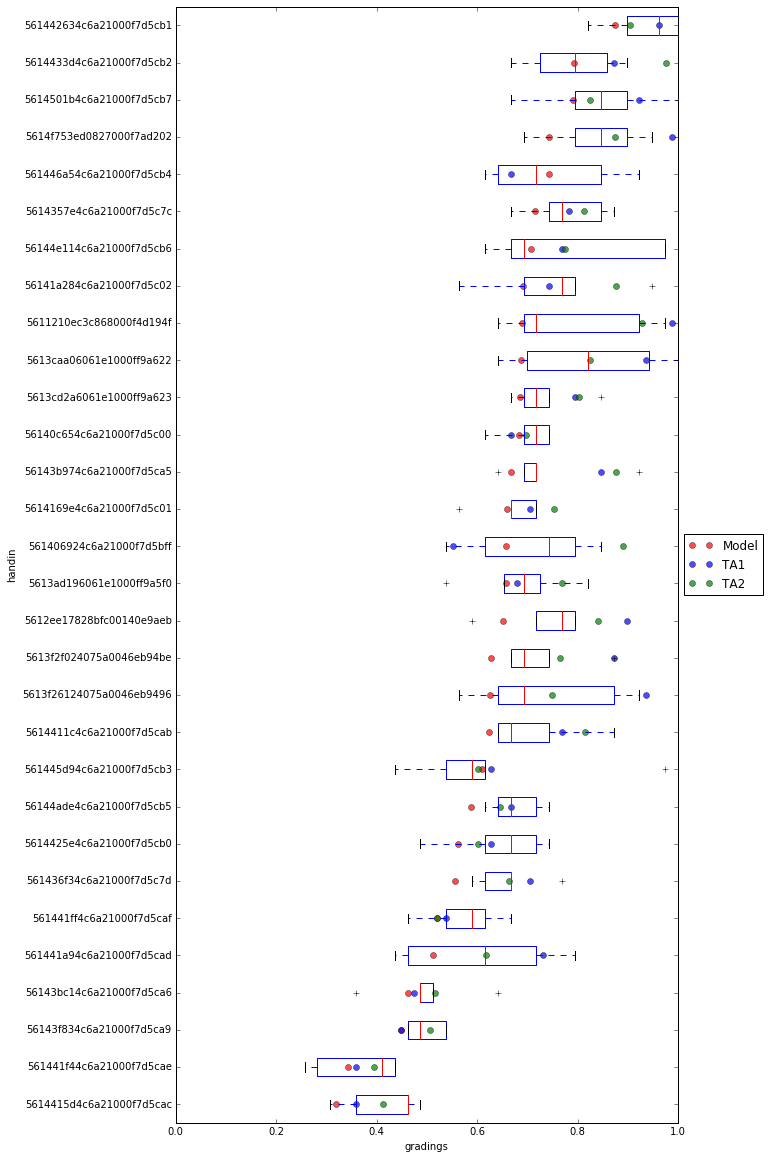

In [239]:
plot_result_ass1(ObjectId("5602625c568a61000f81eddd"),data_course,mcmc_c,find_T)

#### Assignment 2 modeled on all data with TAs

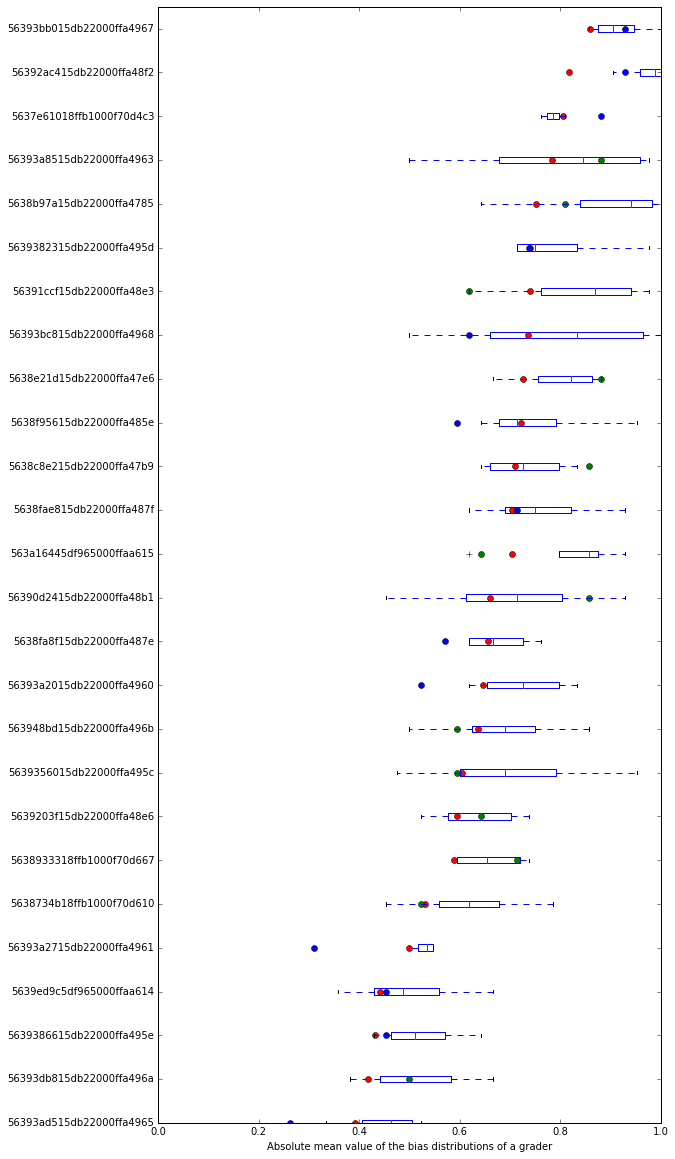

In [176]:
plot_result(ObjectId("562d0edb79c852000f99c6dd"),data_course,mcmc_c,find_T)

## Closer analysing

We have some of the observed hadnins where the distribution of gradings are strange.
An example is xxx where the both TA's differ wildly compared to the grading of the students

TA1: 56151d31ed0827000f7ad204

TA2: 56151d6bed0827000f7ad205

### Assignment 1

Each hadnin in Assignment 1 contains gradings from both TA's. The gradings from the TA's is based on a continues value in the range of 0 to 5 which differes in the way that the other graders have graded handins where their grading value is discret.
Note worthy handins to look into to:
 - 56143b974c6a21000f7d5ca5 Both TA's have graded higher than almost all the graders or the model estimation
 - 5611210ec3c868000f4d194f Both TA's have graded higher than most grader or model finds

I first need to be able to display the difference between the questions in a good way which the next couple of cells of code is to perform

In [571]:
def question_grades_handin(handin_id):
    assignment_id = handin_of_assignment(handin_id)
    TA1_data, TA2_data = get_TA_scores(assignment_id, False)
    data_plt = answer_handin(handin_id)
    if str(handin_id) in TA1_data:
        data_plt.append((TA1_data[str(handin_id)],'TA1'))
    if str(handin_id) in TA2_data:
        data_plt.append((TA2_data[str(handin_id)],'TA2'))
    return data_plt

In [507]:
import colorsys

def pseudocolor(val, minval, maxval):
    h = (float(val-minval) / (maxval-minval)) * 120
    r, g, b = colorsys.hsv_to_rgb(h/360, 1., 1.)
    return '#%02x%02x%02x' % (r*255, g*255, b*255)

In [508]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for i, row in enumerate(self):
            html.append("<tr>")
            if i == 0:
                for col in row:
                    html.append("<td>{0}</td>".format(col))
            else:   
                html.append("<td>{0}</td>".format(row[0]))
                for col in row[1:]:
                    hexc = pseudocolor(col,0,1)
                    html.append("<td bgcolor={0}>{1}</td>".format(hexc,col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [663]:
def question_ListTable(handin_id,mcmc):
    data_plt = question_grades_handin(handin_id)
    n = 13
    names = [""]
    scores = [[] for x in xrange(n)]
    q_label = ["Q%i" % (x+1) for x in xrange(n)]
    for i, q in enumerate(q_label):
        scores[i].append(q)
        for j, (gradings, name) in enumerate(data_plt):
            scores[i].append(gradings[i])
    mean = ['mean']
    bias = ['bias']
    for (gradings, name) in data_plt:
        mean.append(np.mean(gradings))
        if "TA" not in str(name):
            names.append(user_name(name).encode('utf-8'))
            bias.append(np.mean(mcmc[0].trace('B_mu_%s' % str(name))[:]))
        else:
            names.append(name.encode('utf-8'))

    table = ListTable()  
    table.append(names)
    table.extend(scores)
    table.append(mean)
    table.append(bias)
    print "MCMC method found the handin to have the score %f" % np.mean(mcmc[0].trace('T_mu_%s' % str(handin_id))[:])
    return table

#### 56143b974c6a21000f7d5ca5

From the graph we see that both TA's have graded higher than almost all the graders or the model estimation

In [664]:
question_ListTable(ObjectId('56143b974c6a21000f7d5ca5'),mcmc_c)

MCMC method found the handin to have the score 0.628375


,Sarah Alice Mc Gillion,William James Maddocks,Xavier Pidelaserra Martí,Tomasz Grzegorz Nowak,Geekiyanage Trevone Roshant Fernando,TA1,TA2
Q1,1.0,0.666666666667,0.666666666667,1.0,0.666666666667,0.666666666667,0.833333333333
Q2,1.0,0.666666666667,0.666666666667,1.0,0.666666666667,1.0,0.666666666667
Q3,0.666666666667,0.666666666667,0.666666666667,0.333333333333,0.666666666667,1.0,0.833333333333
Q4,1.0,0.666666666667,0.666666666667,0.666666666667,0.666666666667,1.0,1.0
Q5,1.0,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.833333333333,1.0
Q6,1.0,1.0,0.666666666667,0.666666666667,0.666666666667,0.833333333333,0.833333333333
Q7,1.0,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.833333333333,1.0
Q8,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.833333333333,1.0
Q9,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.833333333333,0.833333333333
Q10,1.0,0.666666666667,0.666666666667,0.333333333333,0.333333333333,0.833333333333,0.833333333333


#### 5611210ec3c868000f4d194f

Both TA's have graded higher than most grader or model finds

In [666]:
question_ListTable(ObjectId('5611210ec3c868000f4d194f'),mcmc_c)

MCMC method found the handin to have the score 0.641479


,Yannis Flet-Berliac,Simon Mørup Carlsson,Cezar-Costin Pirvu,Mircea Barba,Mikkel Liisborg Hansen,TA1,TA2
Q1,0.666666666667,0.666666666667,1.0,0.666666666667,0.666666666667,1.0,0.9
Q2,0.333333333333,0.666666666667,1.0,1.0,0.666666666667,1.0,0.666666666667
Q3,0.333333333333,0.666666666667,1.0,1.0,0.666666666667,1.0,0.666666666667
Q4,0.666666666667,0.666666666667,1.0,1.0,0.666666666667,1.0,1.0
Q5,1.0,1.0,1.0,1.0,0.666666666667,1.0,1.0
Q6,0.666666666667,0.666666666667,1.0,1.0,0.666666666667,1.0,1.0
Q7,0.666666666667,0.666666666667,1.0,1.0,1.0,1.0,1.0
Q8,0.666666666667,0.666666666667,1.0,1.0,0.666666666667,1.0,1.0
Q9,0.666666666667,0.666666666667,1.0,1.0,1.0,1.0,1.0
Q10,0.666666666667,0.666666666667,1.0,1.0,1.0,1.0,1.0


In this case we see 3 graders who grade the handin low compared 2 the two others who grade it equally high. Then the TAs a very positive. Q12 have received low score from 3 graders. Medium for two others and high for the two TAs

### Assignment 2

Handins in Assignment 2 are only graded by one TA. Unlike Assigment 1 the gradings from the TA's are graded the same way as the other graders.
Note worthy handins to look into to:
 - 56393a2715db22000ffa4961 TA have graded lower than compared to the models estimate and other graders.
 - 5637e61018ffb1000f70d4c3 TA have graded slightly higher compared to the model and other graders
 - 56392ac415db22000ffa48f2 Model have under estimated compared to the TA and other graders

### 56393a2715db22000ffa4961

TA have graded lower than compared to the models estimate and other graders.

In [667]:
question_ListTable(ObjectId('56393a2715db22000ffa4961'),mcmc_c)

MCMC method found the handin to have the score 0.500732


,Mikkel Liisborg Hansen,Pernille Julie Hansen,Linards Kalnins,Andreas Sikker Kongshaug,TA2
Q1,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.666666666667
Q2,1.0,0.666666666667,0.666666666667,0.666666666667,0.666666666667
Q3,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.333333333333
Q4,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.333333333333
Q5,0.666666666667,0.666666666667,1.0,1.0,0.666666666667
Q6,1.0,0.666666666667,0.666666666667,0.333333333333,0.666666666667
Q7,0.333333333333,0.666666666667,0.666666666667,0.666666666667,0.0
Q8,0.0,0.0,0.0,0.0,0.0
Q9,0.666666666667,0.666666666667,0.666666666667,0.666666666667,0.0
Q10,0.0,0.0,0.0,0.0,0.0


Here the TA's feedback is way more negative than the other graders. And the other graders does agree with each other. The TA have given the Q7 and Q9 the lowest score which means the handin have not answered these question at all. However a closer inspection reveals that the handins does contain answeres for these two questions. Which means that the TA is not trustworthy here

### 5637e61018ffb1000f70d4c3

TA have graded slightly higher compared to the model and other graders

In [668]:
question_ListTable(ObjectId('5637e61018ffb1000f70d4c3'),mcmc_c)

MCMC method found the handin to have the score 0.745952


,Simon Bjørn Thordal,Emil Gensby,Sergey Poltavtsev,TA2
Q1,0.666666666667,1.0,1.0,1.0
Q2,0.666666666667,0.666666666667,0.666666666667,1.0
Q3,0.666666666667,1.0,0.666666666667,0.666666666667
Q4,1.0,0.666666666667,0.666666666667,0.666666666667
Q5,0.666666666667,0.666666666667,0.666666666667,1.0
Q6,1.0,0.666666666667,0.666666666667,1.0
Q7,1.0,0.666666666667,1.0,0.666666666667
Q8,0.666666666667,0.666666666667,1.0,0.666666666667
Q9,1.0,1.0,1.0,1.0
Q10,0.666666666667,0.666666666667,0.666666666667,1.0


The handin have received a very high score from all parties.
The graders agree on qiestion Q2, Q5, Q9, Q10 and Q11 where TA only agrees with the graders on Q9 and have given higher score on the other mentioned questions.

### 56392ac415db22000ffa48f2

Model have under estimated compared to the TA and other graders

In [669]:
question_ListTable(ObjectId('56392ac415db22000ffa48f2'),mcmc_c)

MCMC method found the handin to have the score 0.753212


,Mikkel Baand Rasmussen,John Johannesen,John Jeremy Ireland,Konstantinos Michail,TA2
Q1,1.0,1.0,1.0,1.0,1.0
Q2,1.0,1.0,1.0,1.0,1.0
Q3,1.0,1.0,1.0,1.0,1.0
Q4,1.0,1.0,1.0,1.0,1.0
Q5,1.0,1.0,1.0,1.0,0.666666666667
Q6,1.0,1.0,0.666666666667,1.0,1.0
Q7,1.0,1.0,1.0,1.0,0.666666666667
Q8,1.0,1.0,0.666666666667,1.0,1.0
Q9,1.0,1.0,1.0,1.0,1.0
Q10,1.0,1.0,0.666666666667,1.0,1.0


Here we see that all parties agree that the handin should receive a high grading but two graders have given the report a perfect score. on Q11 the TA and two graders have given the same score of 2 out of 3 while two other graders have given them a perfect score.